## Example of running DLGA on real PDE data (KdV equation)

### Visualization Checklist:
1. Training Process Visualization
   - 1.1 Training Loss Curve
   - 1.2 Validation Loss Curve
   - 1.3 Optimization Analysis (weights & diversity)
   - 1.4 Evolution Visualization

2. Solution Analysis
   - 2.1 PDE Solution Comparison
   - 2.2 Residual Analysis
   - 2.3 Time Slice Comparison

3. Equation Discovery Analysis
   - 3.1 Term Relationship Plot
   - 3.2 Metadata Plane Visualization
   - 3.3 Derivative Relationships

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from pathlib import Path

# Add project root to Python path
current_dir = os.path.dirname(os.path.abspath('__file__'))
kd_main_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(kd_main_dir)

from kd.dataset import load_kdv_equation
from kd.model.kd_dlga import KD_DLGA
from kd.viz.dlga_viz import *
from kd.viz.dlga_kdv import *
from kd.viz.equation_renderer import *

## 1. Load and prepare data

In [2]:
kdv_data = load_kdv_equation()
x, t, u = kdv_data.x, kdv_data.t, kdv_data.usol

# Extract data
X_train, y_train = kdv_data.sample(n_samples=1000)

## 2. Model training

In [3]:
# Initialize model
model = KD_DLGA(
    operators=['u', 'u_x', 'u_xx', 'u_xxx'],
    epi=0.1,
    input_dim=2,
    verbose=False,  # Set to False to avoid verbose output
)

# Train the model
print("\nTraining DLGA model...")
model.fit(X_train, y_train)



Training DLGA model...
===============train Net=================
iter_num: 500      loss: 0.00891475    loss_validate: 0.00865462
iter_num: 1000      loss: 0.00253616    loss_validate: 0.00245512
iter_num: 1500      loss: 0.00115254    loss_validate: 0.00107601
iter_num: 2000      loss: 0.00058128    loss_validate: 0.00068741
iter_num: 2500      loss: 0.00034521    loss_validate: 0.00047868
iter_num: 3000      loss: 0.00047894    loss_validate: 0.00052724
iter_num: 3500      loss: 0.00018231    loss_validate: 0.00023082
iter_num: 4000      loss: 0.00014732    loss_validate: 0.00018470
iter_num: 4500      loss: 0.00012441    loss_validate: 0.00015840
iter_num: 5000      loss: 0.00010843    loss_validate: 0.00014411
iter_num: 5500      loss: 0.00011681    loss_validate: 0.00015133
iter_num: 6000      loss: 0.00008747    loss_validate: 0.00013016
iter_num: 6500      loss: 0.00007661    loss_validate: 0.00012549
iter_num: 7000      loss: 0.00006885    loss_validate: 0.00012150
iter_num: 7

100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


Final solution debug info:
Chromosome length: 2
Coefficient shape: (2, 1)
Chromosome: [[3], [0, 1]]
Coefficients: [[-0.00245071]
 [-0.9834407 ]]
equation form: u_t=-0.0025*u_xxx-0.9834*u*u_x

[Equation Renderer INFO] Successfully received data from DLGA:

[Equation Renderer INFO] (Note: Using dynamic operator list for translation: ['u', 'u_x', 'u_xx', 'u_xxx'])
  Original chromosome (list of modules, a module is a list of gene indices):
    Term 1 - Module (gene indices): [3]
      Meaning (product of terms): uxxx
    Term 2 - Module (gene indices): [0, 1]
      Meaning (product of terms): u * ux
  Coefficients (NumPy array, corresponding to each module/term in the chromosome):
    Term 1 - Coefficient: -0.0025
    Term 2 - Coefficient: -0.9834
  Left-hand side term name (string): u_t
  (Note: Gene indices in the chromosome map to the following list: ['u', 'ux', 'uxx', 'uxxx', 'ut', 'utt'])
--- Equation Renderer data reception end ---

[Equation Renderer INFO]: LaTeX: $u_t = - 0.0025 

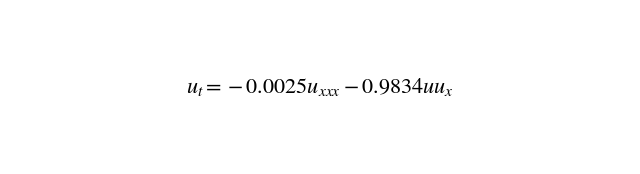

In [4]:
render_latex_to_image(model.eq_latex)

## 3. Generate predictions

In [5]:
print("\nGenerating predictions...")

# Create full grid for visualization
X_full = kdv_data.mesh()
# Convert to tensor and predict
X_tensor = torch.from_numpy(X_full.astype(np.float32)).to(model.device)
with torch.no_grad():
    u_pred = model.Net(X_tensor).cpu().numpy().reshape(u.shape)


Generating predictions...


## 4. Visualizations

Setting up the global plotting style

In [6]:
print("\nCreating visualizations...")

# Configure global plotting style
configure_plotting(cmap='viridis')


Creating visualizations...


### 1. Training Process Visualization
#### 1.1 Training Loss Curve

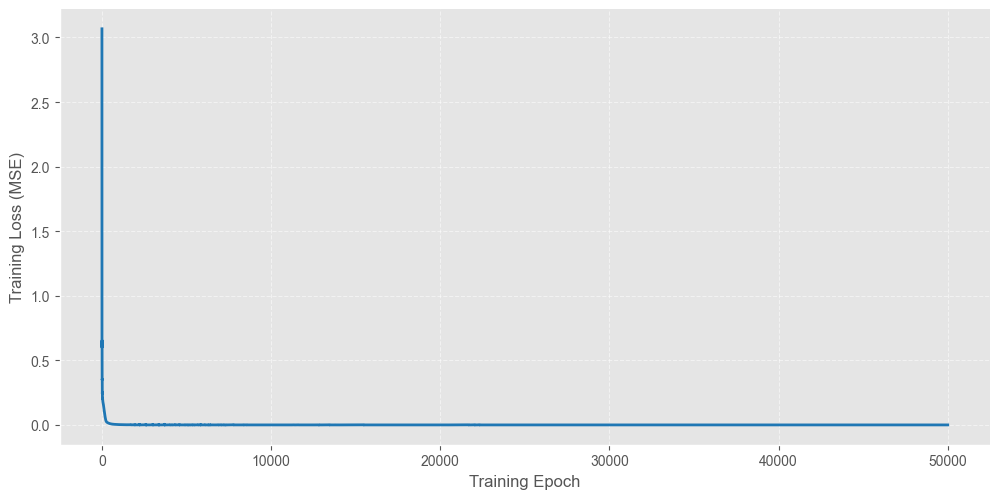

In [7]:
plot_training_loss(model)

#### 1.2 Validation Loss Curve

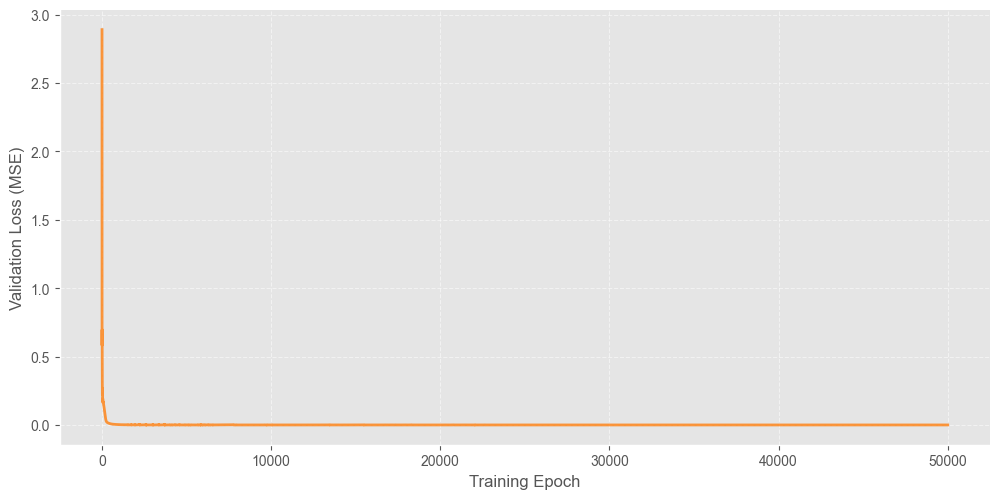

In [8]:
plot_validation_loss(model)

#### 1.3 Optimization Analysis (weights & diversity history)

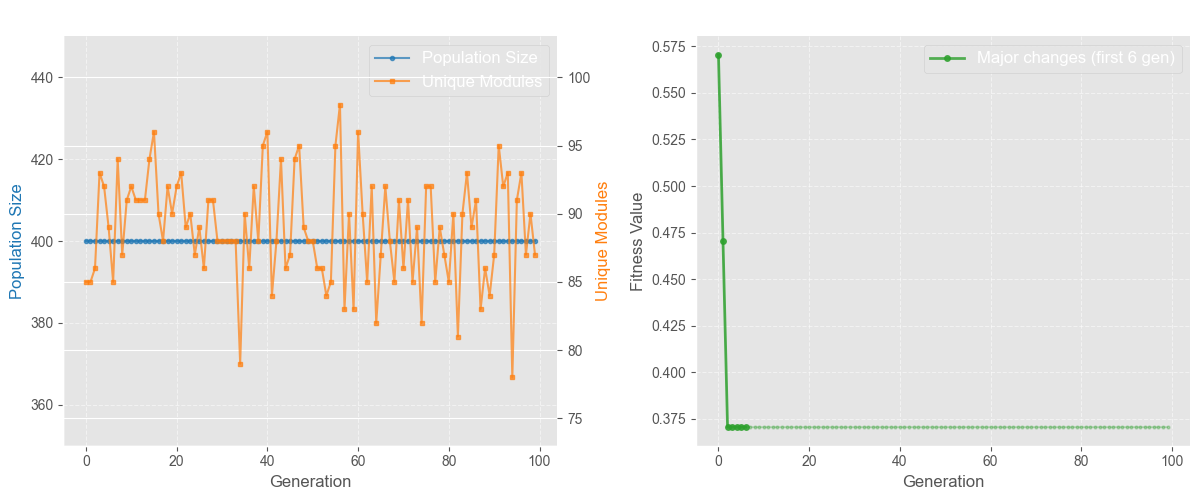


Optimization Analysis Summary:
Initial fitness: 0.5704
Final fitness: 0.3705
Major improvements occurred in first 6 generations
Improvement in major change period: 35.06%
Total improvement: 35.06%
Average population size: 400.0
Average unique modules: 88.9
Diversity ratio: 22.23%


In [9]:
plot_optimization_analysis(model)

#### 1.4 Evolution Visualization

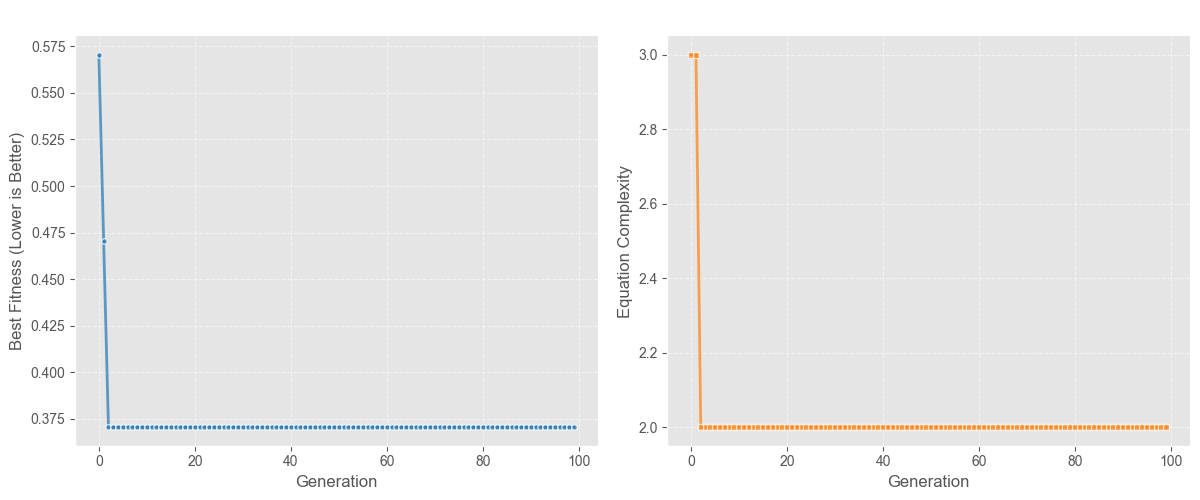


Evolution Analysis Summary:
Initial fitness: 0.5704
Final fitness: 0.3705
Improvement: 35.06%
Initial complexity: 3
Final complexity: 2


In [10]:
plot_evolution(model)

### 2. Solution Analysis
#### 2.1 PDE Solution Comparison

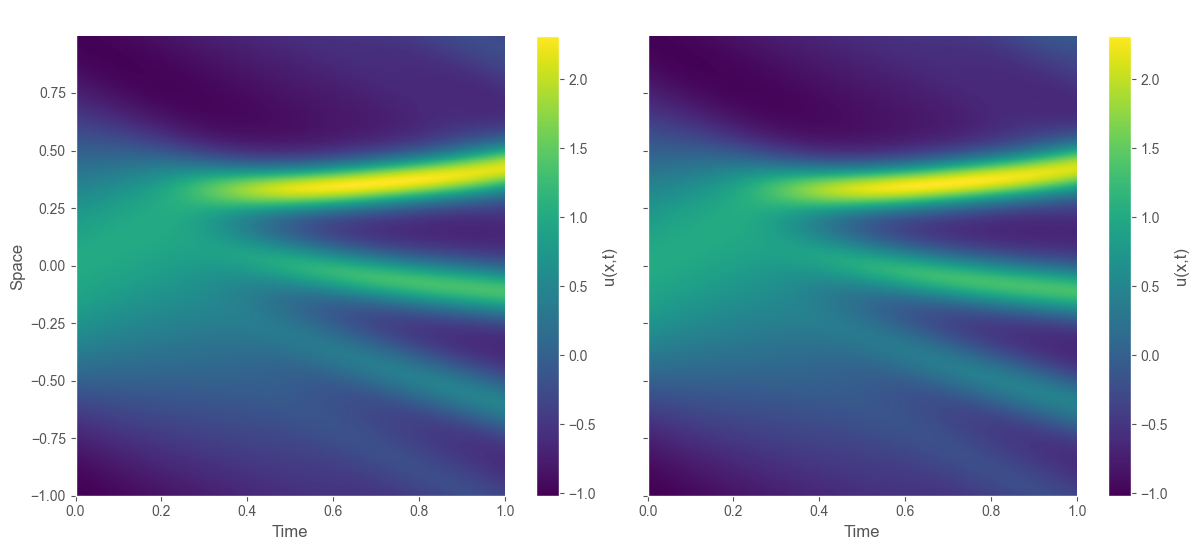

In [11]:
plot_pde_comparison(
    x=x,
    t=t,
    u_true=u,
    u_pred=u_pred
)

#### 2.2 Residual Analysis

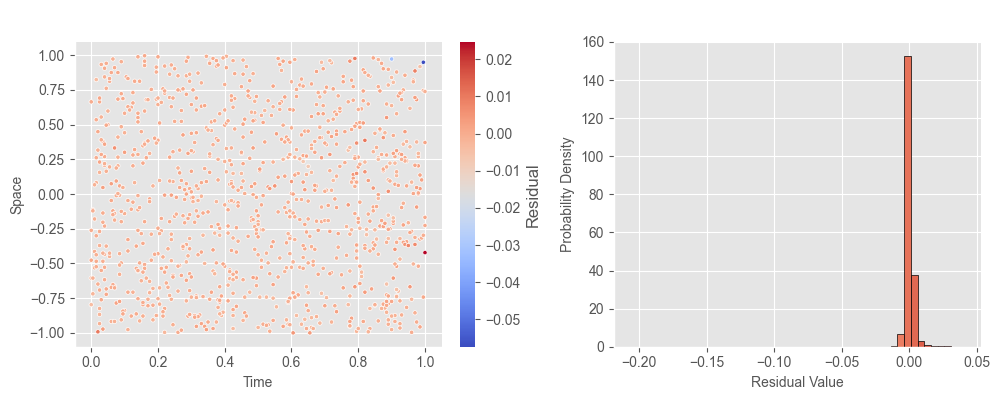

In [12]:
plot_residual_analysis(
    model=model,
    X_train=X_train,
    y_train=y_train,
    u_true=u,
    u_pred=u_pred,
)

#### 2.3 Time Slice Comparison

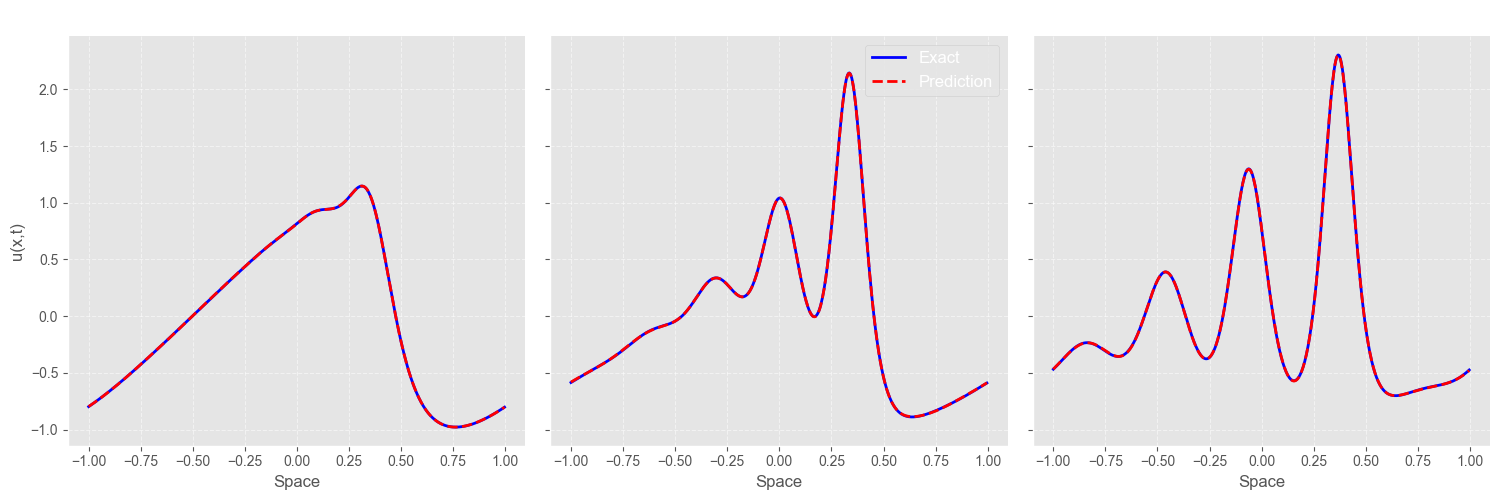

In [13]:
plot_time_slices(
    x=x,
    t=t,
    u_true=u,
    u_pred=u_pred,
    slice_times=[0.25, 0.5, 0.75]
)

### 3. Equation Discovery Analysis
#### 3.1 Term Relationship Plot

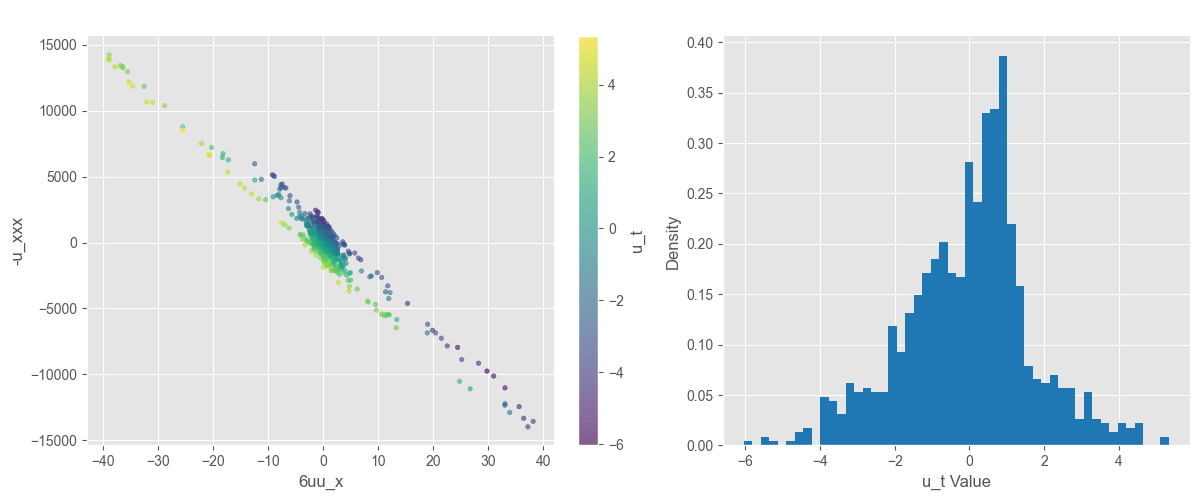

In [14]:
plot_equation_terms(
    model.metadata,
    terms={
        'x_term': {'vars': ['u', 'u_x'], 'label': '6uu_x'},
        'y_term': {'vars': ['u_xxx'], 'label': '-u_xxx'}
    },
    equation_name="KdV Equation",
)

#### 3.2 Metadata Plane Visualization (equation residuals on the x-t plane)


Interpolation info:
Source points shape: (961, 2)
Target grid shape: T=(512, 201), X=(512, 201)
Values shape: u_t=(961,), u=(961,)


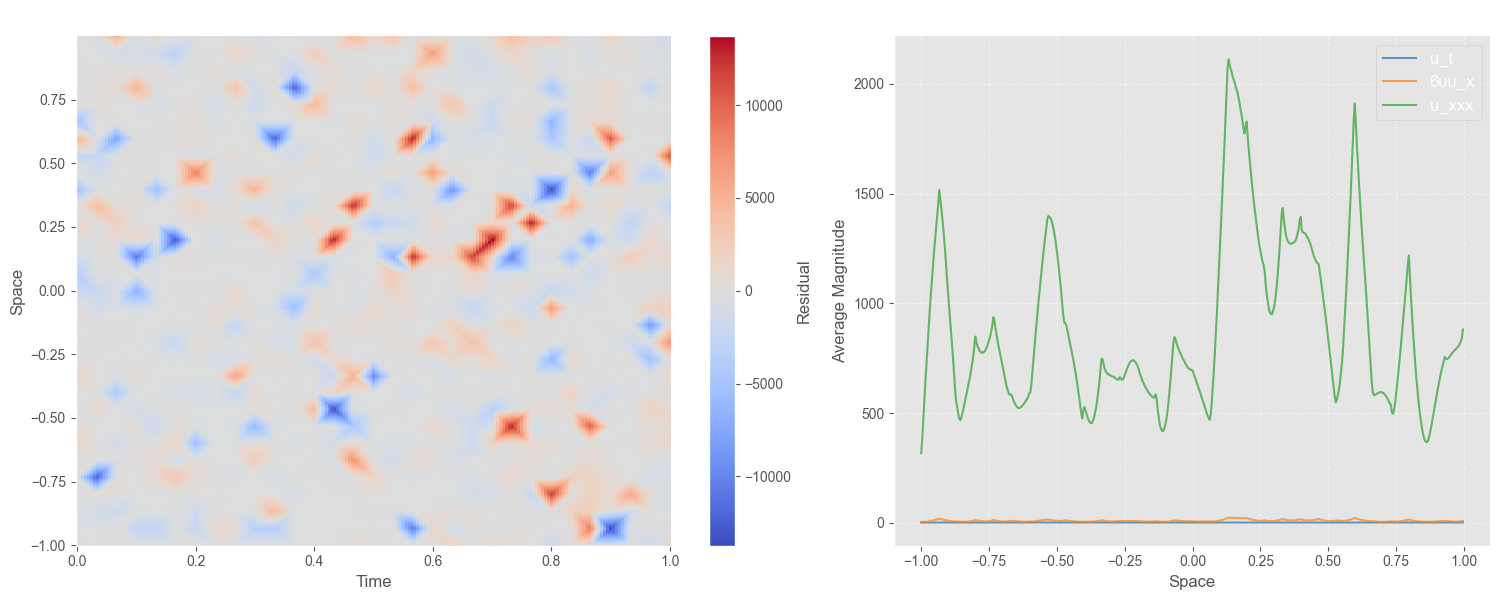


Metadata Plane Analysis:
Residual statistics:
  Mean: -1.3414e+01
  Std:  1.7601e+03
  Max:  1.3728e+04

Term magnitude statistics:
  u_t: 9.3427e-01
  6uu_x: 8.5880e+00
  u_xxx: 8.9193e+02


In [15]:
plot_metadata_plane(metadata=model.metadata, x=x, t=t)

#### 3.3 Derivative Relationships Visualization

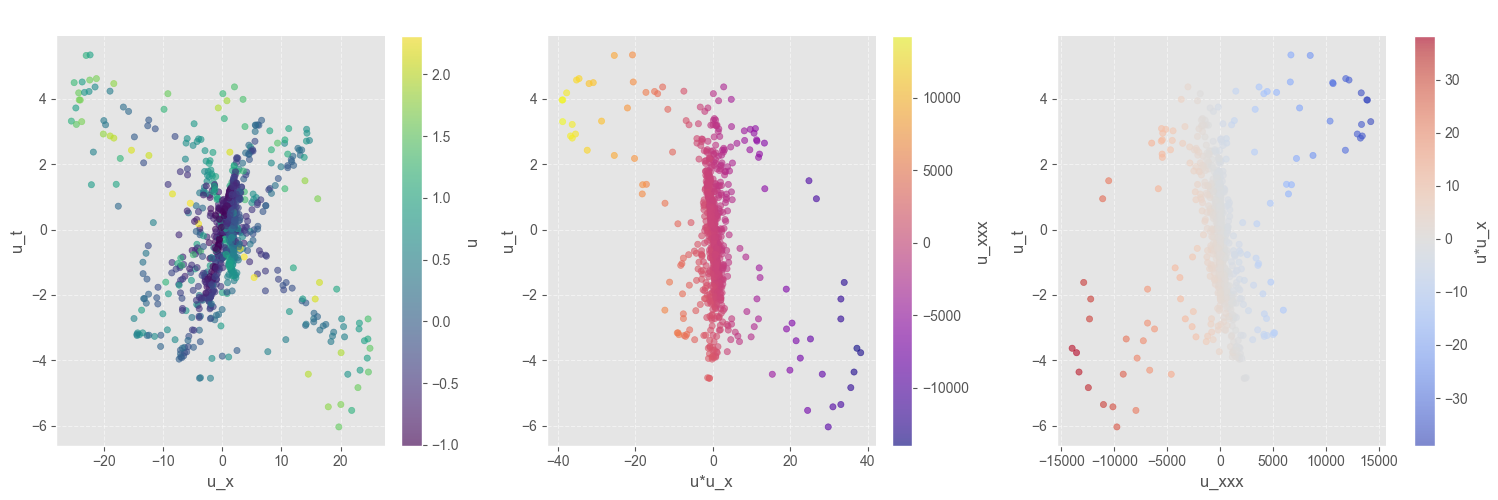

In [16]:
plot_derivative_relationships(metadata=model.metadata)